In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
url_finder = re.compile(r"(?:\@|https?\://)\S+")

def filter_tweet(s):
  s = s.lower()
  s = url_finder.sub("", s) # remove urls and usernames
  return s

In [3]:
df = pd.read_csv(r'tweets.csv')
print(df.head(1))

text = df.text.tolist()
text = [filter_tweet(s) for s in text]

                   id          handle  \
0  780925634159796224  HillaryClinton   

                                                text  is_retweet  \
0  The question in this election: Who can put the...       False   

  original_author                 time in_reply_to_screen_name  \
0             NaN  2016-09-28T00:22:34                     NaN   

   in_reply_to_status_id  in_reply_to_user_id  is_quote_status  \
0                    NaN                  NaN            False   

                         ...                         place_type  \
0                        ...                                NaN   

   place_country_code  place_country  place_contained_within  \
0                 NaN            NaN                     NaN   

   place_attributes place_bounding_box                  source_url truncated  \
0               NaN                NaN  https://studio.twitter.com     False   

                                            entities  \
0  {'media': [{'display_url': 'pi

In [4]:
# transform the text into a data matrix
tfidf = TfidfVectorizer(max_features=150, stop_words=stop_words)
X = tfidf.fit_transform(text).todense()

In [5]:
# subsample for efficiency
# as calculating distances is O(N^2)

N = X.shape[0]
idx = np.random.choice(N, size=2500, replace=False)
x = X[idx]
labels = df.handle[idx].tolist()

In [6]:
# proportions of each label
# so we can be confident that each is represented equally

pTrump = sum(1.0 if e == 'realDonaldTrump' else 0.0 for e in labels) / len(labels)
print("proportion @realDonaldTrump: %.3f" % pTrump)
print("proportion @HillaryClinton: %.3f" % (1 - pTrump))

proportion @realDonaldTrump: 0.490
proportion @HillaryClinton: 0.510


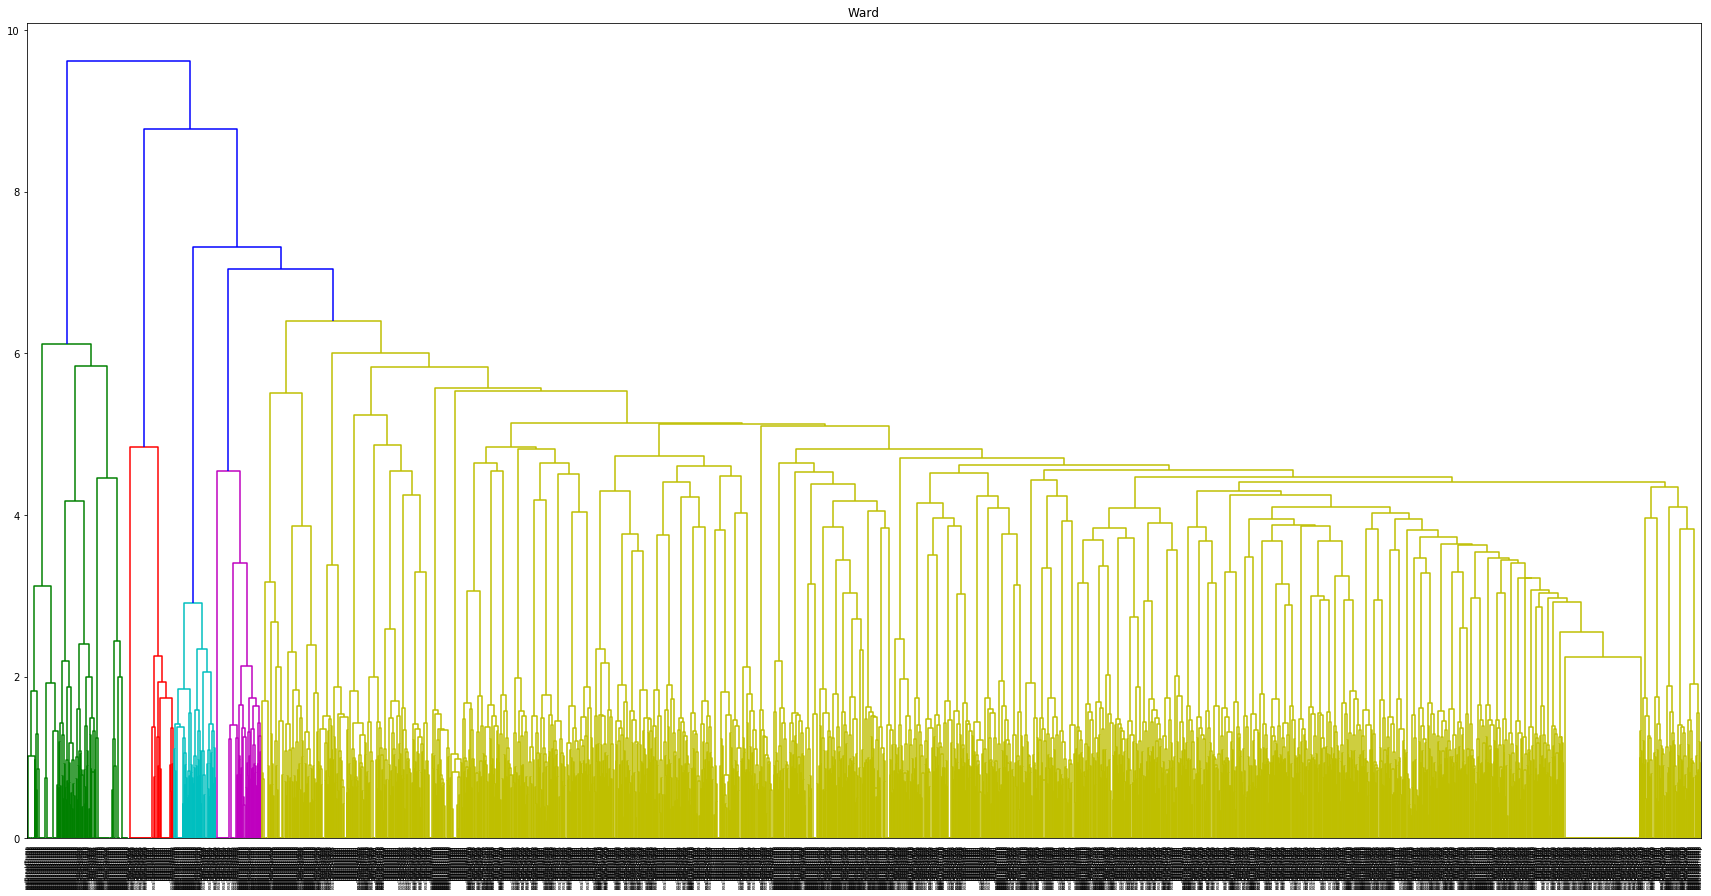

In [7]:
# transform the data matrix into pairwise distances list
dist_array = pdist(x)

# calculate hierarchy
Z = linkage(dist_array, 'ward')

plt.figure(figsize=(30,15))
dendrogram(Z, labels=labels)
plt.title("Ward")
plt.show()

In [8]:
# convert labels to (1, 2), not (0, 1)
# since that's what's returned by fcluster
Y = np.array([1 if e == 'realDonaldTrump' else 2 for e in labels])

In [9]:
# get cluster assignments
# threshold 9 was chosen empirically to yield 2 clusters
C = fcluster(Z, 9, criterion='distance') # returns 1, 2, ..., K
categories = set(C)
# sanity check: should be {1, 2}
print("values in C:", categories)

values in C: {1, 2}


In [10]:
### calculate the purity of our clusters ###
def purity(true_labels, cluster_assignments, categories):
  # maximum purity is 1, higher is better
  N = len(true_labels)

  total = 0.0
  for k in categories:
    max_intersection = 0
    for j in categories:
      intersection = ((cluster_assignments == k) & (true_labels == j)).sum()
      if intersection > max_intersection:
        max_intersection = intersection
    total += max_intersection
  return total / N

print("purity:", purity(Y, C, categories))

purity: 0.5592


In [11]:
if (C == 1).sum() < (C == 2).sum():
  d = 1
  h = 2
else:
  d = 2
  h = 1

In [12]:
actually_donald = ((C == d) & (Y == 1)).sum()
donald_cluster_size = (C == d).sum()
print("purity of @realDonaldTrump cluster:", float(actually_donald) / donald_cluster_size)

actually_hillary = ((C == h) & (Y == 2)).sum()
hillary_cluster_size = (C == h).sum()
print("purity of @HillaryClinton cluster:", float(actually_hillary) / hillary_cluster_size)

purity of @realDonaldTrump cluster: 0.9078947368421053
purity of @HillaryClinton cluster: 0.5366269165247018


In [13]:
# what words have the highest tf-idf in cluster 1? in cluster 2?
w2i = tfidf.vocabulary_

# tf-idf vectorizer todense() returns a matrix rather than array
# matrix always wants to be 2-D, so we convert to array in order to flatten
d_avg = np.array(x[C == d].mean(axis=0)).flatten()
d_sorted = sorted(w2i.keys(), key=lambda w: -d_avg[w2i[w]])

print("\nTop 10 'Donald cluster' words:")
print("\n".join(d_sorted[:10]))


Top 10 'Donald cluster' words:
thank
makeamericagreatagain
trump2016
new
poll
york
trump
great
america
national


In [14]:
h_avg = np.array(x[C == h].mean(axis=0)).flatten()
h_sorted = sorted(w2i.keys(), key=lambda w: -h_avg[w2i[w]])

print("\nTop 10 'Hillary cluster' words:")
print("\n".join(h_sorted[:10]))


Top 10 'Hillary cluster' words:
trump
hillary
great
donald
president
america
people
make
clinton
amp
